In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import subprocess

In [2]:
# this is used to set limits on the y-axis for each device separately
y_limit_dictionary = {
    'Tesla-P100' : [0, 100], 
    'Tesla-V100' : [0, 140], 
    'Tesla-A100' : [0, 230], 
    'AMD-EPYC-64' : [0, 175], 
    'AMD-EPYC-24' : [0, 110], 
    'ARM-NEON' : [0, 190], 
    'INTEL-XEON' : [0, 50], 
    'INTEL-ICY' : [0, 70], 
    'IBM-POWER9' : [0, 55], 
    'Alveo-U280' : [0, 30], 
}

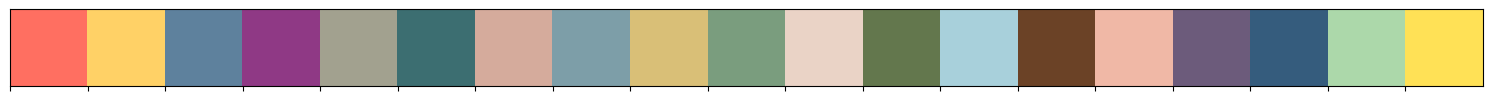

In [3]:
palette = ['#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F','#3C6E71','#D5AB9C','#7D9EA8','#D9BF77','#7A9D7E','#EAD3C6','#63774D','#A8D0DB','#6B4226','#F0B8A6','#6C5B7B','#355C7D','#ACD8AA','#FFE156']
sns.palplot(palette)
plt.show()

In [4]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()


# all devices that will be used
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(1.0, 0.43529411764705883, 0.3803921568627451),
 (1.0, 0.8196078431372549, 0.4),
 (0.3686274509803922, 0.5058823529411764, 0.615686274509804),
 (0.5607843137254902, 0.2235294117647059, 0.5215686274509804),
 (0.6352941176470588, 0.6313725490196078, 0.5607843137254902),
 (0.23529411764705882, 0.43137254901960786, 0.44313725490196076),
 (0.8352941176470589, 0.6705882352941176, 0.611764705882353),
 (0.49019607843137253, 0.6196078431372549, 0.6588235294117647),
 (0.8509803921568627, 0.7490196078431373, 0.4666666666666667),
 (0.47843137254901963, 0.615686274509804, 0.49411764705882355)]

In [5]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [6]:
header_names = ['mtx_name','distribution','placement','seed',
                'm','n','nz','density','A_mem_footprint','mem_range',
                'avg_nz_row','std_nz_row',
                'avg_bandwidth_scaled',
                'skew_coeff', 'avg_num_neighbours','cross_row_similarity',
                'implementation','time','gflops','W_avg','J_estimated', 'System', 'Arch', 'shuffling']

def find_class(mem_footprint):
    low_mb_list =   [4,8, 16,32,64, 128,256,512, 1024,2048, 4096] # removed largest mem range (2048-4096)
    high_mb_list =  [8,16,32,64,128,256,512,1024,2048,4096, 8192]
    for i in range(len(low_mb_list)):
        if(mem_footprint>=low_mb_list[i] and mem_footprint<=high_mb_list[i]):
            pos = i
            mem_range = '['+str(low_mb_list[pos])+'-'+str(high_mb_list[pos])+']'
            return mem_range
    return str(-1)

In [160]:
def modify_footprint(v):
    if(v["implementation"]=="CSR5_9"):
        return (v["A_mem_footprint"] - 4*(v["m"]+v["n"]))/(1024*1024.0)
    else:
        return v["A_mem_footprint"]

def create_complete_gpu_csv(gpu_dataframe, system, arch):
    gpu_dataframe["mtx_name"] = gpu_dataframe["mtx_name"].apply(lambda x: x.split("/")[-1].split(".")[0])
    vm_features = pd.read_csv("../benchmark_results/validation_matrices_features_new_matrices.csv", sep="\t")
    mtx_names = list(vm_features["matrix"]) # same as : list(set(inputdata_GPU["mtx_name"]))

    inputvaldata_GPU = pd.DataFrame(columns=header_names)

    for mtx_name in mtx_names:
        temp_df = pd.DataFrame(columns=header_names)
        for index, curr in gpu_dataframe[gpu_dataframe["mtx_name"] == mtx_name].iterrows():
            mtx_name = mtx_name
            if('_shuffle' in mtx_name):
                # print(mtx_name)
                mtx_name = mtx_name.replace('_shuffle','')
            distribution = "unused"
            placement = "unused"
            seed = curr["seed"]
            m = curr["m"]
            n = curr["n"]
            nz = curr["nz"]
            density = nz/(m*n)*100.0
            A_mem_footprint = curr["A_mem_footprint"]
            mem_range = find_class((nz*(64+32)+32*(m+1))/(8*1024*1024))
            avg_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-avg"])[0]
            std_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-std"])[0]
            avg_bandwidth_scaled = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0]
            skew_coeff = list(vm_features[vm_features["matrix"]==mtx_name]["skew_coeff"])[0]
            avg_num_neighbours = list(vm_features[vm_features["matrix"]==mtx_name]["num-neigh-avg"])[0]
            cross_row_similarity = list(vm_features[vm_features["matrix"]==mtx_name]["cross_row_sim-avg"])[0]
            
            shuffling = curr["shuffling"]
            implementation = curr["implementation"]
            if(shuffling != ' '):
                implementation = curr["implementation"] + "_" + shuffling
            time = curr["time"]
            gflops = curr["gflops"]
            W_avg = curr["W_avg"]
            J_estimated = curr["J_estimated"]
            

            new_row = {'mtx_name' : mtx_name, 'distribution' : distribution, 'placement' : placement, 'seed' : seed, 
                       'm' : m, 'n' : n, 'nz' : nz, 'density' : density, 'A_mem_footprint' : A_mem_footprint, 'mem_range' : mem_range, 
                       'avg_nz_row' : avg_nz_row, 'std_nz_row' : std_nz_row, 
                       'avg_bandwidth_scaled' : avg_bandwidth_scaled,
                       'skew_coeff' : skew_coeff, 'avg_num_neighbours' : avg_num_neighbours, 'cross_row_similarity' : cross_row_similarity,
                       'implementation' : implementation, 'time' : time, 'gflops' : gflops, 'W_avg' : W_avg, 'J_estimated' : J_estimated,
                       'shuffling': shuffling}
            temp_df = pd.concat([temp_df, pd.DataFrame([new_row])], ignore_index=True)            
        # inputvaldata_GPU = pd.concat([inputvaldata_GPU, pd.DataFrame([new_row])], ignore_index=True)
        inputvaldata_GPU = pd.concat([inputvaldata_GPU, temp_df], ignore_index=True)
        
    inputvaldata_GPU['System'] = system
    inputvaldata_GPU['Arch'] = arch
    if(system=='Tesla-V100'):
        inputvaldata_GPU["A_mem_footprint"] = inputvaldata_GPU.apply(lambda x: modify_footprint(x), axis=1)
    inputvaldata_GPU.sort_values(by='A_mem_footprint', ascending=True, inplace=True)
    
    groupvalreps = inputvaldata_GPU.groupby( ['mtx_name','distribution','placement','seed',
                                          'm','n','nz','density','A_mem_footprint','mem_range',
                                          'avg_nz_row','std_nz_row',
                                          'avg_bandwidth_scaled',
                                          'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                          'implementation','System', 'Arch', 'shuffling']).mean().reset_index().reindex(columns=header_names)
    
    # because gflops=0 (for this matrix merge did not run successfully) was bad for geomean calculation
    groupvalreps = groupvalreps[groupvalreps['mtx_name'] != 'kron_g500-logn20']
    
    def calc_geomean(df):
        # Calculate the geomean gflops for each format_name
        geomean_gflops = df.groupby('implementation')['gflops'].apply(lambda x: np.exp(np.mean(np.log(x))))

        # Create a new DataFrame for the average values
        geomean_df = pd.DataFrame({'mtx_name': ['Geomean'] * len(geomean_gflops),
                                   'implementation': geomean_gflops.index,
                                   'gflops': geomean_gflops.values,
                                   'A_mem_footprint': [10000] * len(geomean_gflops)})

        # Append the average information to the original DataFrame
        new_df = pd.concat([df, geomean_df], ignore_index=True)
        return new_df
    
    groupvalreps_geomean = calc_geomean(groupvalreps)
    # print(groupvalreps_geomean[groupvalreps_geomean['mtx_name'] == 'Geomean'])
    inputvaldata_GPU = groupvalreps_geomean
    return inputvaldata_GPU

In [161]:
def read_gpu_data(fname):
    # it has different data layout @@@ panastas @@@
    gpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
                                                                'm','n','nz','density','A_mem_footprint','mem_range',
                                                                'avg_nz_row','std_nz_row',
                                                                'avg_bandwidth','std_bandwidth','avg_scattering','std_scattering',
                                                                '1','2','3','4','5','6','7',
                                                                'implementation','time','gflops','W_avg', 'J_estimated', 'shuffling'])
    arch, system = 'GPU', 'Tesla-A100'
    gpu_data["mtx_name"] = gpu_data["mtx_name"].apply(lambda x: x.split("/")[-1].split(".")[0]) + gpu_data["shuffling"].apply(lambda x: '_' + x if x!=' ' else '')
    gpu_data = create_complete_gpu_csv(gpu_data, system, arch)
    return gpu_data


In [162]:
%%time
gpu_data_NORMAL = read_gpu_data("epyc5-A100/epyc5-A100_dtype-D_run_validation_matrices_trash_NORMAL_output.csv")
gpu_data_NORMAL

    mtx_name distribution placement  seed   m   n  nz  density  \
138  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
139  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
140  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
141  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
142  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
143  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   

     A_mem_footprint mem_range  ...  avg_num_neighbours  cross_row_similarity  \
138          10000.0       NaN  ...                 NaN                   NaN   
139          10000.0       NaN  ...                 NaN                   NaN   
140          10000.0       NaN  ...                 NaN                   NaN   
141          10000.0       NaN  ...                 NaN                   NaN   
142          10000.0       NaN  ...                 NaN                   NaN   
143          10000.0       NaN  ...                

,mtx_name,distribution,placement,seed,m,n,nz,density,A_mem_footprint,mem_range,...,avg_num_neighbours,cross_row_similarity,implementation,time,gflops,W_avg,J_estimated,System,Arch,shuffling
0,CurlCurl_2,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.715522,0.524131,Merge_11,0.000146,122.490200,248.7596,0.036011,Tesla-A100,GPU,
1,CurlCurl_2,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.715522,0.524131,Merge_11_shuffle,0.000154,116.011800,249.2974,0.038255,Tesla-A100,GPU,shuffle
2,CurlCurl_2,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.715522,0.524131,cuSPARSE_coo11,0.000139,128.506400,249.1052,0.034662,Tesla-A100,GPU,
3,CurlCurl_2,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.715522,0.524131,cuSPARSE_coo11_shuffle,0.000139,128.790400,248.4968,0.034322,Tesla-A100,GPU,shuffle
4,CurlCurl_2,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.715522,0.524131,cuSPARSE_csr11,0.000123,144.909600,250.5262,0.030053,Tesla-A100,GPU,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,Merge_11_shuffle,NaN,122.776445,NaN,NaN,NaN,NaN,NaN
140,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11,NaN,139.819006,NaN,NaN,NaN,NaN,NaN
141,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11_shuffle,NaN,130.239778,NaN,NaN,NaN,NaN,NaN
142,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_csr11,NaN,147.694498,NaN,NaN,NaN,NaN,NaN


In [164]:
%%time
gpu_data_RCM = read_gpu_data("epyc5-A100/epyc5-A100_dtype-D_run_validation_matrices_trash_RCM_output.csv")
gpu_data_RCM

    mtx_name distribution placement  seed   m   n  nz  density  \
138  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
139  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
140  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
141  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
142  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
143  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   

     A_mem_footprint mem_range  ...  avg_num_neighbours  cross_row_similarity  \
138          10000.0       NaN  ...                 NaN                   NaN   
139          10000.0       NaN  ...                 NaN                   NaN   
140          10000.0       NaN  ...                 NaN                   NaN   
141          10000.0       NaN  ...                 NaN                   NaN   
142          10000.0       NaN  ...                 NaN                   NaN   
143          10000.0       NaN  ...                

,mtx_name,distribution,placement,seed,m,n,nz,density,A_mem_footprint,mem_range,...,avg_num_neighbours,cross_row_similarity,implementation,time,gflops,W_avg,J_estimated,System,Arch,shuffling
0,CurlCurl_2_rcm,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.588559,0.566054,Merge_11,0.000147,121.484600,249.7928,0.036603,Tesla-A100,GPU,
1,CurlCurl_2_rcm,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.588559,0.566054,Merge_11_shuffle,0.000176,101.827360,248.5446,0.042002,Tesla-A100,GPU,shuffle
2,CurlCurl_2_rcm,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.588559,0.566054,cuSPARSE_coo11,0.000140,127.731000,248.7962,0.034723,Tesla-A100,GPU,
3,CurlCurl_2_rcm,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.588559,0.566054,cuSPARSE_coo11_shuffle,0.000149,119.563600,250.4200,0.037431,Tesla-A100,GPU,shuffle
4,CurlCurl_2_rcm,unused,unused,0.0,806529.0,806529.0,8921789.0,0.001372,105.178,[64-128],...,0.588559,0.566054,cuSPARSE_csr11,0.000125,143.324600,245.4624,0.029658,Tesla-A100,GPU,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,Merge_11_shuffle,NaN,120.695176,NaN,NaN,NaN,NaN,NaN
140,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11,NaN,141.185835,NaN,NaN,NaN,NaN,NaN
141,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11_shuffle,NaN,130.553924,NaN,NaN,NaN,NaN,NaN
142,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_csr11,NaN,148.789471,NaN,NaN,NaN,NaN,NaN


In [163]:
%%time
gpu_data_SMALL_CRS = read_gpu_data("epyc5-A100/epyc5-A100_dtype-D_run_validation_matrices_trash_SMALL_CRS_output.csv")
gpu_data_SMALL_CRS


    mtx_name distribution placement  seed   m   n  nz  density  \
324  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
325  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
326  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
327  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
328  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   
329  Geomean          NaN       NaN   NaN NaN NaN NaN      NaN   

     A_mem_footprint mem_range  ...  avg_num_neighbours  cross_row_similarity  \
324          10000.0       NaN  ...                 NaN                   NaN   
325          10000.0       NaN  ...                 NaN                   NaN   
326          10000.0       NaN  ...                 NaN                   NaN   
327          10000.0       NaN  ...                 NaN                   NaN   
328          10000.0       NaN  ...                 NaN                   NaN   
329          10000.0       NaN  ...                

,mtx_name,distribution,placement,seed,m,n,nz,density,A_mem_footprint,mem_range,...,avg_num_neighbours,cross_row_similarity,implementation,time,gflops,W_avg,J_estimated,System,Arch,shuffling
0,12month1,unused,unused,0.0,12471.0,872622.0,22624727.0,0.207901,258.967,[256-512],...,0.529541,0.124633,Merge_11,0.000229,197.881800,249.5772,0.055789,Tesla-A100,GPU,
1,12month1,unused,unused,0.0,12471.0,872622.0,22624727.0,0.207901,258.967,[256-512],...,0.529541,0.124633,Merge_11_shuffle,0.000228,198.295600,250.2650,0.057119,Tesla-A100,GPU,shuffle
2,12month1,unused,unused,0.0,12471.0,872622.0,22624727.0,0.207901,258.967,[256-512],...,0.529541,0.124633,cuSPARSE_coo11,0.000470,96.263440,179.7034,0.084501,Tesla-A100,GPU,
3,12month1,unused,unused,0.0,12471.0,872622.0,22624727.0,0.207901,258.967,[256-512],...,0.529541,0.124633,cuSPARSE_coo11_shuffle,0.000478,94.748380,180.7452,0.086348,Tesla-A100,GPU,shuffle
4,12month1,unused,unused,0.0,12471.0,872622.0,22624727.0,0.207901,258.967,[256-512],...,0.529541,0.124633,cuSPARSE_csr11,0.000460,98.348420,155.1324,0.071351,Tesla-A100,GPU,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,Merge_11_shuffle,NaN,131.788893,NaN,NaN,NaN,NaN,NaN
326,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11,NaN,105.584329,NaN,NaN,NaN,NaN,NaN
327,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_coo11_shuffle,NaN,103.086736,NaN,NaN,NaN,NaN,NaN
328,Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.000,NaN,...,NaN,NaN,cuSPARSE_csr11,NaN,104.438613,NaN,NaN,NaN,NaN,NaN


In [165]:
def plot_it(df, what):
    # Plot the barplot
    # plt.figure(figsize=(10, 6))
    hue_order = ['cuSPARSE_coo11', 'cuSPARSE_coo11_shuffle', 
                 'cuSPARSE_csr11', 'cuSPARSE_csr11_shuffle', 
                 'Merge_11',       'Merge_11_shuffle']
    ax = sns.barplot(x='mtx_name', y='gflops', hue='implementation', data=df, errorbar=None, hue_order=hue_order)

    # Set the legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

    # Add a legend indicating shuffled or not
    # for label in palette:
    #     ax.bar(0, 0, color=palette[label], label=f'Shuffled: {label}', alpha=0)

    # Remove the y-axis label (since it's GFLOPs)
    ax.set_ylabel('')
    
    # Extract only the pairs of interest
    pairs_of_interest = [(hue_order[0], hue_order[1]), (hue_order[2], hue_order[3]), (hue_order[4], hue_order[5])]
    
    # Calculate percentage difference and annotate the plot for the specified pairs
    # Calculate percentage difference and annotate the plot
    cnt=0
    print(len(ax.patches))
    len_matrices = len(ax.patches)//len(hue_order)
    print('len_matrices', len_matrices)
    for k in [0,2,4]:
        for i in range(k*len_matrices, k*len_matrices+len_matrices):
            if (ax.patches[i].get_width()) > 0 and (ax.patches[i].get_height() > 0):  # Exclude empty bars
                # annotation_text = f'{i}'
                annotation_text = f'{(ax.patches[i].get_height() - ax.patches[i+len_matrices].get_height())/ax.patches[i].get_height() * 100:.2f}%'
                ax.annotate(annotation_text, (ax.patches[i].get_x() + ax.patches[i].get_width() , ax.patches[i].get_height() + 5), 
                            ha='center', va='center', fontsize=5, color='black', xytext=(0, 5), 
                            rotation=90, textcoords='offset points')
        

    plt.xticks(rotation=90)

    # Show the plot
    # plt.show()
    plt.tight_layout()
    fig_name = './shuffling_effect/epyc5_shuffling_effect_%s.pdf' % (what)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])



In [166]:
plt.rc('figure', figsize=(2.5 * width,2 * height))
plot_it(gpu_data_NORMAL, 'NORMAL')

144
len_matrices 24


In [167]:
plt.rc('figure', figsize=(2.5 * width,2 * height))
plot_it(gpu_data_RCM, 'RCM')

144
len_matrices 24


In [168]:
plt.rc('figure', figsize=(4 * width,2 * height))
plot_it(gpu_data_SMALL_CRS, 'SMALL_CRS')

330
len_matrices 55


In [169]:
plt.rc('figure', figsize=(2.5 * width,2 * height))
plot_it(gpu_data_SMALL_CRS[gpu_data_SMALL_CRS['cross_row_similarity']<=0.05], 'SMALL_CRS_below_0.05')

102
len_matrices 17
